In [142]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
tf.keras.backend.floatx()

'float32'

In [143]:
# House Hold Energy Data - Time Series
df = pd.read_csv('D202.csv')
df

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES
0,Electric usage,10/22/2016,0:00,0:14,0.01,kWh,$0.00,NaN
1,Electric usage,10/22/2016,0:15,0:29,0.01,kWh,$0.00,NaN
2,Electric usage,10/22/2016,0:30,0:44,0.01,kWh,$0.00,NaN
3,Electric usage,10/22/2016,0:45,0:59,0.01,kWh,$0.00,NaN
4,Electric usage,10/22/2016,1:00,1:14,0.01,kWh,$0.00,NaN
...,...,...,...,...,...,...,...,...
70363,Electric usage,10/24/2018,22:45,22:59,0.02,kWh,$0.00,NaN
70364,Electric usage,10/24/2018,23:00,23:14,0.03,kWh,$0.01,NaN
70365,Electric usage,10/24/2018,23:15,23:29,0.03,kWh,$0.01,NaN
70366,Electric usage,10/24/2018,23:30,23:44,0.03,kWh,$0.01,NaN


In [144]:
df.isnull().sum()

TYPE              0
DATE              0
START TIME        0
END TIME          0
USAGE             0
UNITS             0
COST              0
NOTES         70368
dtype: int64

In [145]:
df_baru = df.drop(columns=['TYPE','START TIME','END TIME','UNITS','COST','NOTES'])
# mencari niai USAGE paling rendah
print(df_baru['USAGE'].max())
# mencari nilai USAGE paling tinggi
print(df_baru['USAGE'].min())

2.36
0.0


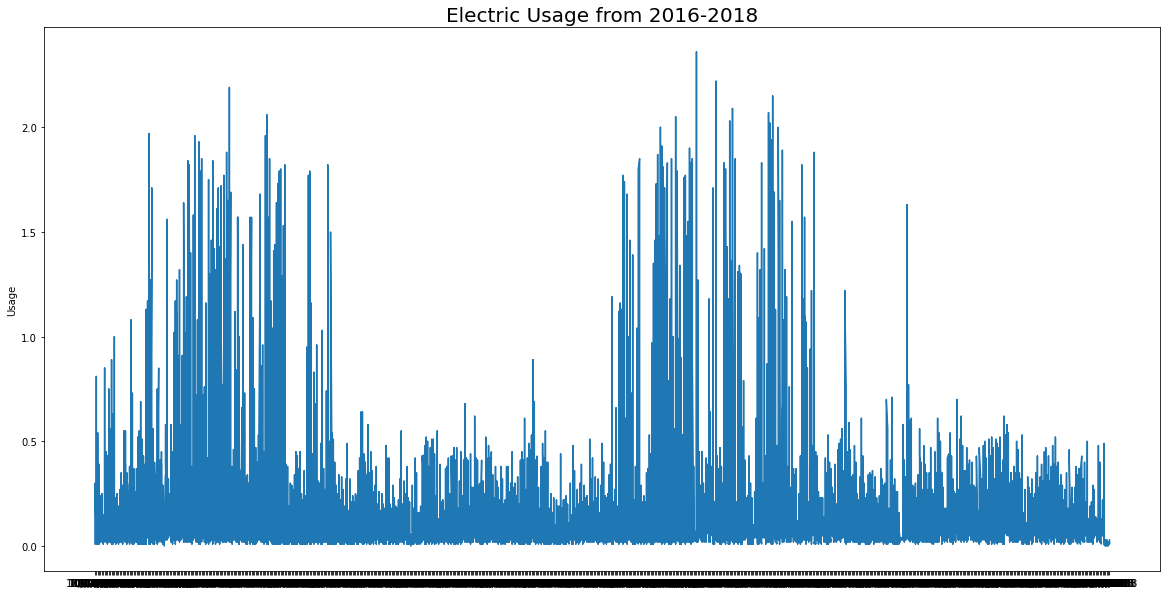

In [146]:
    date = df['DATE'].values
    usage = df['USAGE'].values

    plt.figure(figsize=(20,10))
    plt.plot(date,usage)
    plt.ylabel('Usage')
    plt.title('Electric Usage from 2016-2018',
              fontsize=20);

In [147]:
from sklearn.model_selection import train_test_split
data_latih, data_test, label_latih, label_test = train_test_split(usage, date, test_size=0.2)

In [148]:
    def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
        series = tf.expand_dims(series, axis=-1)
        ds = tf.data.Dataset.from_tensor_slices(series)
        ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
        ds = ds.flat_map(lambda w: w.batch(window_size + 1))
        ds = ds.shuffle(shuffle_buffer)
        ds = ds.map(lambda w: (w[:-1], w[1:]))
        return ds.batch(batch_size).prefetch(1)

In [149]:
    train_set = windowed_dataset(data_latih, window_size=60, batch_size=5000, shuffle_buffer=1000)
    val_set = windowed_dataset(data_test, window_size=60, batch_size=5000, shuffle_buffer=1000)
    model = tf.keras.models.Sequential([
      tf.keras.layers.LSTM(60, return_sequences=True),
      tf.keras.layers.LSTM(60),
      tf.keras.layers.Dense(30, activation="relu"),
      tf.keras.layers.Dense(10, activation="relu"),
      tf.keras.layers.Dense(1),
    ])

In [150]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < 0.236) :
      print("\nMAE kurang dari 10%")
      self.model.stop_training = True
callbacks = myCallback()

In [151]:
    optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])
    history = model.fit(train_set, epochs=30, callbacks=[callbacks], validation_data=(val_set))

Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

     12/Unknown - 38s 3s/step - loss: 0.0272 - mae: 0.1189
MAE kurang dari 10%
12/12 [==============================] - 44s 4s/step - loss: 0.0272 - mae: 0.1189 - val_loss: 0.0266 - val_mae: 0.1178


In [152]:
import matplotlib.pyplot as plt

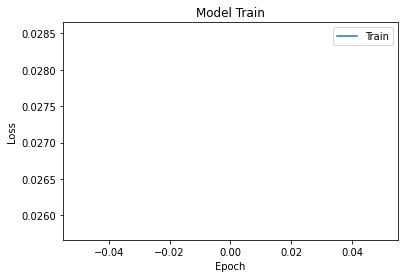

In [153]:
plt.plot(history.history['loss'])
plt.title('Model Train')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

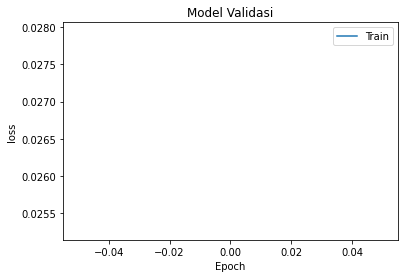

In [154]:
plt.plot(history.history['val_loss'])
plt.title('Model Validasi')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()